# Probablistic model building genetic algorithm

In [1]:
%cd /mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder

/mnt/home/zzhang/anaconda3/envs/crispr/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)
Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import gc
from sklearn.model_selection import train_test_split

## Load data

In [4]:
x = np.load('./data/compiled_X.npy')
y = np.load('./data/compiled_Y.npy')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=777)

## Setup AMBER

In [5]:
import amber
print(amber.__version__)
from amber.architect import pmbga
from amber.architect import ModelSpace, Operation

0.1.1-ga


In [6]:
kinn_model_space = ModelSpace.from_dict([
    # k_01, sol -> open R-loop
    [dict(Layer_type='conv1d', filters=1, SOURCE='0', TARGET='1', 
          kernel_size=1,
          EDGE=1,
          RANGE_ST=pmbga.Categorical(choices=[0,1,2,3,4], prior_cnt=[1]*5),
          RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1), 
     )],
    # k_10, open R-loop -> sol
    [dict(Layer_type='conv1d', filters=1, SOURCE='1', TARGET='0', 
          kernel_size=1,
          EDGE=1,
          RANGE_ST=pmbga.Categorical(choices=[0,1,2,3,4], prior_cnt=[1]*5),
          RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1),          
     )],
    # k_12, open R-loop -> intermediate R-loop
    [dict(Layer_type='conv1d', filters=1, SOURCE='1', TARGET='2', 
          kernel_size=1, 
          EDGE=1,
          RANGE_ST=pmbga.Categorical(choices=[5,6,7,8,9,10], prior_cnt=[1]*6),
          RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1), 
     )],
    # k_21, intermediate R-loop -> open R-loop
    [dict(Layer_type='conv1d', filters=1, SOURCE='2', TARGET='1', 
          kernel_size=1, 
          EDGE=1,
          RANGE_ST=pmbga.Categorical(choices=[5,6,7,8,9,10], prior_cnt=[1]*6),
          RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1),             
     )],
    # k_23, intermediate R-loop -> closed R-loop
    [dict(Layer_type='conv1d', filters=1, SOURCE='2', TARGET='3', 
          kernel_size=1, 
          EDGE=1,
          RANGE_ST=pmbga.Categorical(choices=[11,12,13,14,15,16,17,18], prior_cnt=[1]*8),
          RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1),     
     )],
    # k_32
    [dict(Layer_type='conv1d', kernel_size=1, filters=1, SOURCE='3', TARGET='2', 
          EDGE=1,        
          RANGE_ST=pmbga.Categorical(choices=[11,12,13,14,15,16,17,18], prior_cnt=[1]*8),
          RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1),          
     )],
    # k_30
    [dict(Layer_type='conv1d', kernel_size=1, filters=1, SOURCE='3', TARGET='0', 
          EDGE=1,
          RANGE_ST=pmbga.Categorical(choices=np.arange(0,19), prior_cnt=[1]*19),
          RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1), 
          CONTRIB=1
     )],
])
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [7]:
controller = pmbga.ProbaModelBuildGeneticAlgo(
            model_space=kinn_model_space,
            buffer_type='population',
            buffer_size=50,  # buffer size controlls the max history going back
            batch_size=1,   # batch size does not matter in this case; all arcs will be retrieved
        )

## Components before they are implemented in AMBER

In [8]:
## NEEDS RE-WORK
# poorman's manager get reward
def get_reward_pipeline(model_arcs):
    from warnings import simplefilter
    simplefilter(action='ignore', category=DeprecationWarning)
    train_graph = tf.Graph()
    train_sess = tf.Session(graph=train_graph)
    model_params = modelSpace_to_modelParams(model_arcs)
    with train_graph.as_default(), train_sess.as_default():
        kinn_test = KineticModel(model_params)
        mb = KineticNeuralNetworkBuilder(kinn=kinn_test, session=train_sess, n_channels=13)
        # train and test
        mb.build(optimizer='adam', plot=False, output_act=True)
        model = mb.model
        x_train_b = mb.blockify_seq_ohe(x_train)
        x_test_b = mb.blockify_seq_ohe(x_test)
        checkpointer = ModelCheckpoint(filepath="bestmodel.h5", mode='min', verbose=0, save_best_only=True,
                               save_weights_only=True)
        earlystopper = EarlyStopping(
            monitor="val_loss",
            mode='min',
            patience=5,
            verbose=0)

        model.fit(x_train_b, y_train[:,1],
                  batch_size=64,
                  validation_split=0.2,
                  epochs=25, verbose=0)
        y_hat = model.predict(x_test_b).flatten()
        test_pcc = ss.pearsonr(y_hat, y_test[:,1])[0]
    del train_graph, train_sess
    gc.collect()
    return test_pcc

## A fancy For-Loop that does the work for `amber.architect.trainEnv`

In [9]:
# trainEnv parameters
samps_per_gen = 10   # how many arcs to sample in each generation; important
max_gen = 200
epsilon = 0.05
patience = 100
n_warmup_gen = -1

In [10]:
def compute_eps(model_space_probs, old_probs=None):
    delta = []
    samp_probs = {}
    for p in model_space_probs:
        #print(p)
        samp_probs[p] = model_space_probs[p].sample(size=10000)
        n = np.percentile(samp_probs[p], [10, 20, 30, 40, 50, 60, 70, 80, 90])
        if old_probs is None:
            delta.append( np.mean(np.abs(n)) )
        else:
            o = np.percentile(old_probs[p], [10, 20, 30, 40, 50, 60, 70, 80, 90])
            delta.append( np.mean(np.abs(o - n)) )
    return np.mean(delta), samp_probs 

# get prior probas
_, old_probs = compute_eps(controller.model_space_probs)

In [11]:
hist = []
pc_cnt = 0
best_indv = 0
stat_df = pd.DataFrame(columns=['Generation', 'GenAvg', 'Best', 'PostVar'])
for generation in range(max_gen):
    try:
        start = time.time()
        has_impr = False
        #for _ in tqdm(range(samps_per_gen), total=samps_per_gen, position=0, leave=True):
        for _ in range(samps_per_gen):
            # get arc
            arc, _ = controller.get_action()
            # get reward
            try:
                test_pcc = get_reward_pipeline(arc)
            except ValueError:
                test_pcc = 0
            except Exception as e:
                raise e
            rate_df = None
            # update best, or increase patience counter
            if test_pcc > best_indv:
                best_indv = test_pcc
                has_impr = True
            # store
            _ = controller.store(action=arc, reward=test_pcc)
            hist.append({'gen': generation, 'arc':arc, 'test_pcc': test_pcc, 'rate_df': rate_df})
        end = time.time()
        if generation < n_warmup_gen:
            print(f"Gen {generation} < {n_warmup_gen} warmup.. skipped - Time %.2f" % (end-start), flush=True)
            continue
        _ = controller.train(episode=generation, working_dir=".")
        delta, old_probs = compute_eps(controller.model_space_probs, old_probs)
        post_vars = [np.var(x.sample(size=100)) for _, x in controller.model_space_probs.items()]
        stat_df = stat_df.append({
            'Generation': generation,
            'GenAvg': controller.buffer.r_bias,
            'Best': best_indv,
            'PostVar': np.mean(post_vars)
        }, ignore_index=True)
        print("[%s] Gen %i - Mean fitness %.3f - Best %.4f - PostVar %.3f - Eps %.3f - Time %.2f" % (
            datetime.now().strftime("%H:%M:%S"),
            generation, 
            controller.buffer.r_bias, 
            best_indv, 
            np.mean(post_vars),
            delta,
            end-start), flush=True)
        #if delta < epsilon:
        #    print("stop due to convergence criteria")
        #    break
        pc_cnt = 0 if has_impr else pc_cnt+1
        if pc_cnt >= patience:
            print("early-stop due to max patience w/o improvement")
            break
    except KeyboardInterrupt:
        print("user interrupted")
        break

datapoints:  6 / total:  10
[10:38:23] Gen 0 - Mean fitness 0.117 - Best 0.2712 - PostVar 5.796 - Eps 0.532 - Time 59.01
datapoints:  11 / total:  20
[10:39:34] Gen 1 - Mean fitness 0.152 - Best 0.2714 - PostVar 6.132 - Eps 0.352 - Time 65.60
datapoints:  15 / total:  30
[10:40:47] Gen 2 - Mean fitness 0.188 - Best 0.2714 - PostVar 6.245 - Eps 0.321 - Time 67.16
datapoints:  22 / total:  40
[10:42:07] Gen 3 - Mean fitness 0.185 - Best 0.2759 - PostVar 5.941 - Eps 0.198 - Time 73.90
datapoints:  27 / total:  50
[10:43:20] Gen 4 - Mean fitness 0.197 - Best 0.2759 - PostVar 5.865 - Eps 0.238 - Time 67.79
datapoints:  37 / total:  60
[10:44:26] Gen 5 - Mean fitness 0.169 - Best 0.2759 - PostVar 5.864 - Eps 0.127 - Time 60.64
datapoints:  40 / total:  70
[10:45:32] Gen 6 - Mean fitness 0.186 - Best 0.2855 - PostVar 5.572 - Eps 0.119 - Time 59.79
datapoints:  44 / total:  80
[10:46:52] Gen 7 - Mean fitness 0.194 - Best 0.2855 - PostVar 6.223 - Eps 0.119 - Time 75.16
datapoints:  45 / total: 

datapoints:  281 / total:  500
[12:07:13] Gen 66 - Mean fitness 0.249 - Best 0.2986 - PostVar 5.708 - Eps 0.111 - Time 93.28
datapoints:  230 / total:  500
[12:08:51] Gen 67 - Mean fitness 0.259 - Best 0.3017 - PostVar 5.675 - Eps 0.079 - Time 92.45
datapoints:  341 / total:  500
[12:10:23] Gen 68 - Mean fitness 0.235 - Best 0.3017 - PostVar 5.607 - Eps 0.111 - Time 85.69
datapoints:  217 / total:  500
[12:12:03] Gen 69 - Mean fitness 0.260 - Best 0.3017 - PostVar 5.856 - Eps 0.103 - Time 94.12
datapoints:  264 / total:  500
[12:13:43] Gen 70 - Mean fitness 0.255 - Best 0.3017 - PostVar 5.967 - Eps 0.056 - Time 94.67
datapoints:  261 / total:  500
[12:15:24] Gen 71 - Mean fitness 0.255 - Best 0.3017 - PostVar 5.649 - Eps 0.056 - Time 95.37
datapoints:  379 / total:  500
[12:16:45] Gen 72 - Mean fitness 0.220 - Best 0.3017 - PostVar 6.021 - Eps 0.119 - Time 75.22
datapoints:  352 / total:  500
[12:18:26] Gen 73 - Mean fitness 0.234 - Best 0.3017 - PostVar 5.864 - Eps 0.079 - Time 95.67


[13:55:48] Gen 131 - Mean fitness 0.230 - Best 0.3017 - PostVar 5.839 - Eps 0.087 - Time 104.31
datapoints:  325 / total:  500
[13:57:49] Gen 132 - Mean fitness 0.246 - Best 0.3017 - PostVar 5.455 - Eps 0.071 - Time 115.47
datapoints:  401 / total:  500
[13:59:27] Gen 133 - Mean fitness 0.215 - Best 0.3017 - PostVar 5.232 - Eps 0.111 - Time 92.15
datapoints:  414 / total:  500
[14:01:05] Gen 134 - Mean fitness 0.202 - Best 0.3017 - PostVar 5.261 - Eps 0.095 - Time 92.57
datapoints:  297 / total:  500
[14:03:07] Gen 135 - Mean fitness 0.251 - Best 0.3017 - PostVar 5.587 - Eps 0.206 - Time 116.18
datapoints:  422 / total:  500
[14:04:36] Gen 136 - Mean fitness 0.186 - Best 0.3017 - PostVar 6.272 - Eps 0.159 - Time 82.53
datapoints:  418 / total:  500
[14:06:15] Gen 137 - Mean fitness 0.190 - Best 0.3017 - PostVar 6.005 - Eps 0.032 - Time 93.33
datapoints:  428 / total:  500
[14:07:46] Gen 138 - Mean fitness 0.161 - Best 0.3017 - PostVar 5.961 - Eps 0.063 - Time 85.52
datapoints:  412 / t

datapoints:  377 / total:  500
[16:03:21] Gen 196 - Mean fitness 0.225 - Best 0.3033 - PostVar 5.429 - Eps 0.087 - Time 119.86
datapoints:  152 / total:  500
[16:05:40] Gen 197 - Mean fitness 0.273 - Best 0.3033 - PostVar 5.800 - Eps 0.190 - Time 134.07
datapoints:  403 / total:  500
[16:07:36] Gen 198 - Mean fitness 0.211 - Best 0.3033 - PostVar 5.540 - Eps 0.246 - Time 109.74
datapoints:  402 / total:  500
[16:09:32] Gen 199 - Mean fitness 0.212 - Best 0.3033 - PostVar 5.553 - Eps 0.032 - Time 110.42


In [12]:
pd.DataFrame(hist).sort_values('test_pcc', ascending=False)

,gen,arc,test_pcc,rate_df
1614,161,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.303276,None
670,67,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.301750,None
1296,129,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.300014,None
825,82,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.299983,None
1974,197,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.299332,None
...,...,...,...,...
1175,117,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",-0.017573,None
389,38,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",-0.037281,None
4,0,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",-0.039676,None
1407,140,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",-0.050504,None


In [13]:
a = pd.DataFrame(hist)
a['arc'] = ['|'.join([f"{x.Layer_attributes['RANGE_ST']}-{x.Layer_attributes['RANGE_ST']+x.Layer_attributes['RANGE_D']}" for x in entry]) for entry in a['arc']]
a.drop(columns=['rate_df'], inplace=True)
a.to_csv("train_history.tsv", sep="\t", index=False)

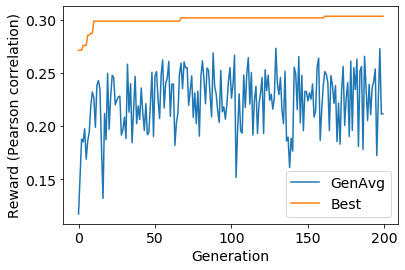

In [21]:
%matplotlib inline

ax = stat_df.plot.line(x='Generation', y=['GenAvg', 'Best'])
ax.set_ylabel("Reward (Pearson correlation)")
ax.set_xlabel("Generation")
plt.savefig("reward_vs_time.png")

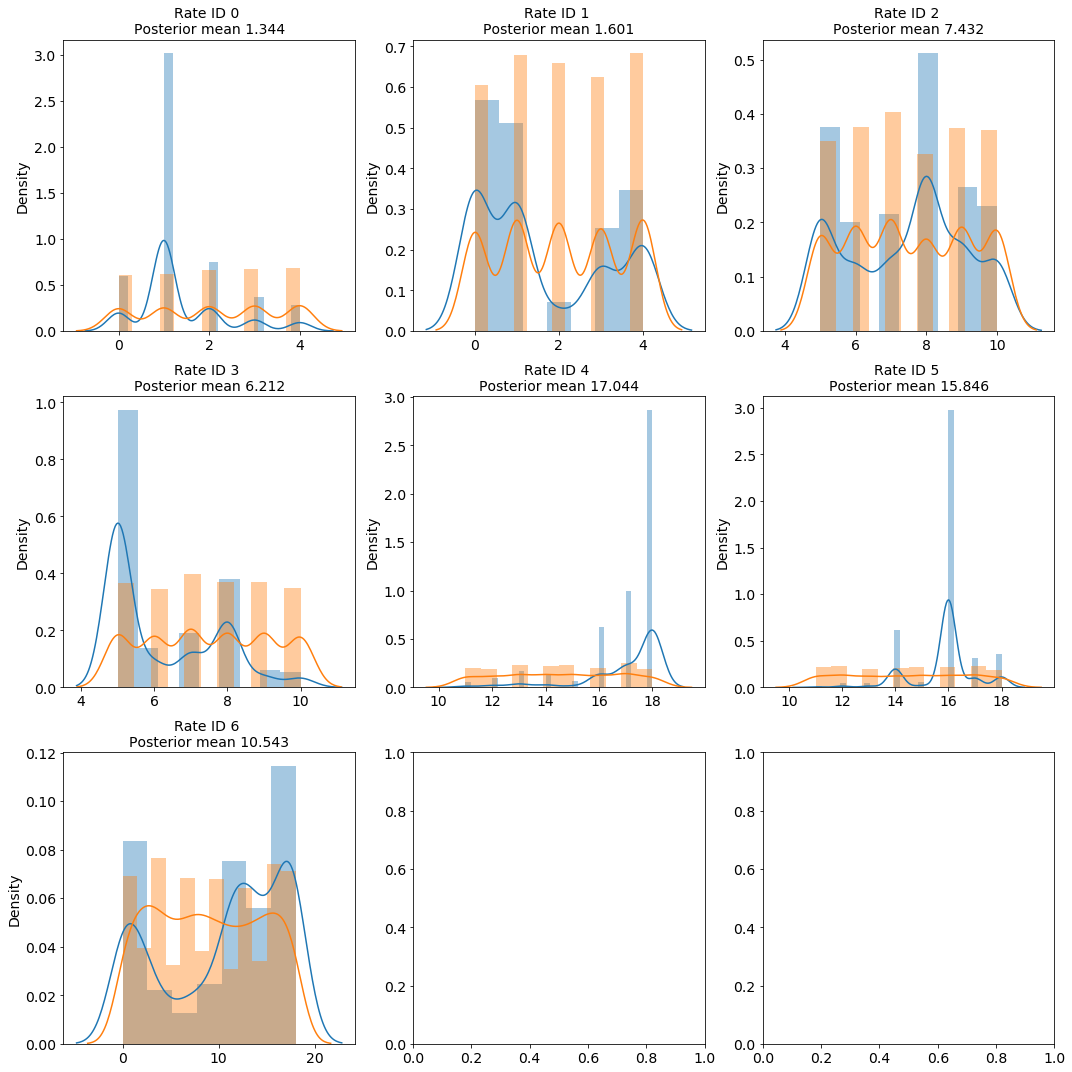

In [20]:
# START SITE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_ST':
        try:
            d = controller.model_space_probs[k].sample(size=1000)
        except:
            continue
        ax = axs[k[0]]
        sns.distplot(d, label="Post", ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        ax.set_title(
            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))

        #_ = ax.set_xlim(0,50)
fig.tight_layout()
fig.savefig("range_st.png")

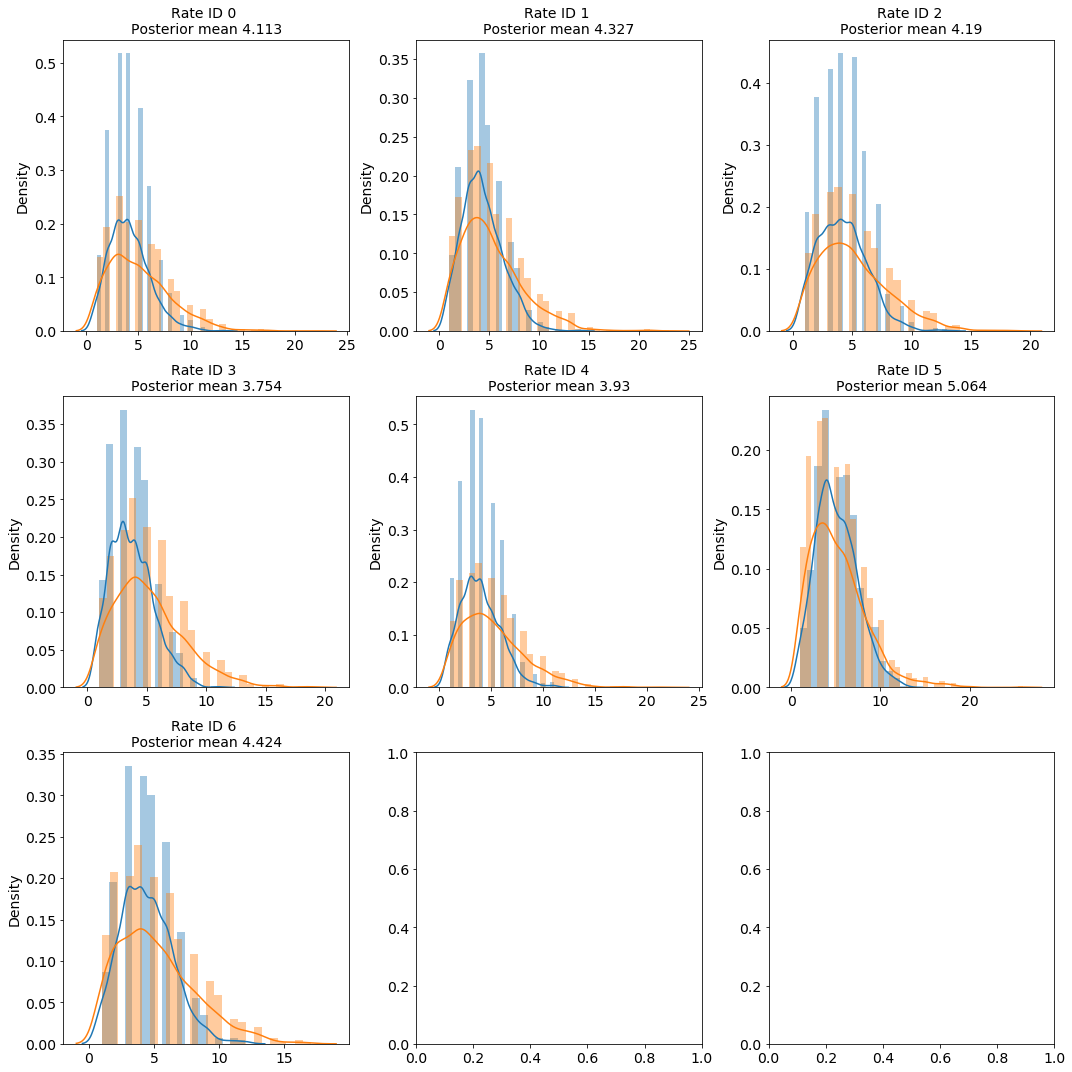

In [22]:
# CONV RANGE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_D':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        ax.set_title(
                ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
        #_ = ax.set_xlim(0,20)    
fig.tight_layout()
fig.savefig("range_d.png")

In [19]:
# EDGE PRESENCE
#fig, axs_ = plt.subplots(3,3, figsize=(15,15))
#axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
#for k in controller.model_space_probs:
#    if k[-1] == 'EDGE':
#        d = controller.model_space_probs[k].sample(size=1000)
#        ax = axs[k[0]]
#        sns.distplot(d, ax=ax)
#        sns.distplot(controller.model_space_probs[k].prior_dist, ax=ax)
#        ax.set_title(
#            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
#        #_ = ax.set_xlim(0,20)    
#fig.tight_layout()